In [2]:
# -*- coding: utf-8 -*-
"""LSM_MNIST_CPU_Vivado.ipynb

Colab notebook to train a LSM (LIF reservoir + ridge readout) on MNIST.
Exports data for Vivado/Verilog simulation.
All math and operations are annotated.
"""

# === Imports ===
import os
import json
import gzip
import numpy as np
from scipy import sparse
from scipy.sparse import random as sparse_random
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# === Mount Google Drive for saving outputs ===
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# === Config ===
OUTPUT_DIR = '/content/drive/MyDrive/LSM_HDL_CPU'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# CPU-friendly parameters
N_INPUT = 784             # MNIST flattened input
N_RESERVOIR = 500         # Reservoir neurons
T_SIM = 100               # Simulation window (ms)
DT = 1.0                  # Euler timestep
N_TRIALS = 3              # Poisson trials per image
MAX_RATE = 120.0          # Max firing rate for Poisson encoding

# LIF neuron parameters
V_THRESH = 1.0
V_RESET = 0.0
V_REST = 0.0
TAU = 20.0
REFRACTORY_MS = 5.0

# Connectivity
DENSITY_W = 0.05          # fraction non-zero in recurrent W
DENSITY_WIN = 0.08        # fraction non-zero in input Win
WIN_STD = 0.12
TARGET_SPECTRAL_RADIUS = 0.95

# Ridge regression
RIDGE_ALPHA = 1.0

# Random seed
SEED = 42
rng = np.random.default_rng(SEED)

# Quantization for Vivado HLS (Q1.15 fixed point)
Q_SHIFT = 15
Q_DTYPE = np.int16

# Load/save flags
LOAD_EXISTING_MODEL = True
SAVE_RESERVOIR_STATES = True

In [4]:
# ---------------- HELPERS ----------------

def make_sparse_random_csr(m, n, density, rng, scale=1.0):
    """
    Create sparse random matrix with Gaussian entries.
    Mathematically: Win[i,j] ~ N(0, scale^2) if non-zero
    Stored as CSR for memory efficiency.
    """
    mat = sparse_random(m, n, density=density,
                        data_rvs=lambda k: rng.normal(0.0, scale, size=k),
                        random_state=rng, format='coo')
    return mat.tocsr().astype(np.float32)

def power_iteration_spectral_radius_sparse(A_csr, n_iter=50):
    """
    Estimate largest eigenvalue (spectral radius) using power iteration:
    b_{k+1} = A*b_k / ||A*b_k||
    """
    n = A_csr.shape[0]
    b = rng.normal(size=(n,),).astype(np.float32)
    for _ in range(n_iter):
        b = A_csr.dot(b)
        b /= np.linalg.norm(b) + 1e-12
    return float(np.linalg.norm(A_csr.dot(b)))

def image_to_spike_bins_poisson(image, t_sim=T_SIM, max_rate=MAX_RATE):
    """
    Convert normalized image to Poisson spike train over T_SIM ms.
    λ = pixel_value * max_rate
    Each pixel fires independently with Poisson statistics.
    Returns list of length T_SIM, each entry = list of spiking pixel indices.
    """
    rates = image * max_rate
    lam = rates * (t_sim / 1000.0)
    counts = rng.poisson(lam)
    nonzero_idx = np.nonzero(counts)[0]
    bins = [[] for _ in range(int(t_sim))]
    for pix in nonzero_idx:
        n_spk = int(counts[pix])
        times = (rng.random(n_spk) * t_sim).astype(int)
        for tt in times:
            bins[tt].append(int(pix))
    return bins

def run_reservoir_sparse(spike_bins, Win_csr, W_csr):
    """
    LIF reservoir simulation:
    V[t+1] = V[t] + dt*(-V[t] + V_rest)/tau + input + recurrent
    Spikes reset V and apply refractory
    """
    V = np.full(N_RESERVOIR, V_REST, dtype=np.float32)
    refrac = np.zeros(N_RESERVOIR, dtype=np.float32)
    activity = []

    for t in range(int(T_SIM)):
        pixels = spike_bins[t]
        if pixels:
            input_contrib = Win_csr[:, pixels].sum(axis=1).A.ravel()
            V += input_contrib
        # Leak (Euler step)
        V += DT * (-V + V_REST) / TAU
        # Spike condition
        spiking = V >= V_THRESH
        if spiking.any():
            V[spiking] = V_RESET
            refrac[spiking] = REFRACTORY_MS
            V += W_csr.dot(spiking.astype(np.float32))
        # Refractory decay
        mask = refrac > 0
        V[mask] = V_RESET
        refrac[mask] -= DT
        activity.append(V.copy())
    return np.mean(activity, axis=0)

def compute_reservoir_states_sparse(Xset, Win_csr, W_csr, N_trials=N_TRIALS):
    """
    Compute reservoir states for each image, averaged over trials.
    """
    N = Xset.shape[0]
    R = np.zeros((N, N_RESERVOIR), dtype=np.float32)
    for i in range(N):
        trial_activities = []
        for _ in range(N_trials):
            bins = image_to_spike_bins_poisson(Xset[i])
            trial_activities.append(run_reservoir_sparse(bins, Win_csr, W_csr))
        R[i] = np.mean(trial_activities, axis=0)
        if (i+1) % 500 == 0 or i == N-1:
            print(f"... processed {i+1}/{N}")
    return R

def train_ridge_closed_form(R, y, alpha=1.0):
    """
    Ridge regression:
    Wout^T = (R^T R + alpha I)^-1 R^T Y
    Y = one-hot of labels
    """
    N, D = R.shape
    classes = np.unique(y)
    C = classes.size
    Y = np.zeros((N, C), dtype=np.float32)
    for i, lab in enumerate(classes):
        Y[:, i] = (y == lab).astype(np.float32)
    A = R.T.dot(R) + alpha*np.eye(D, dtype=np.float32)
    RtY = R.T.dot(Y)
    Wout = np.linalg.solve(A, RtY).T.astype(np.float32)
    return Wout, classes

def predict_from_readout(R, Wout):
    scores = R.dot(Wout.T)
    return np.argmax(scores, axis=1)

def quantize_to_int(arr, qshift=Q_SHIFT, dtype=Q_DTYPE):
    """Q1.15 fixed-point quantization for Vivado HLS"""
    scaled = np.round(arr * (1 << qshift)).astype(np.int64)
    info = np.iinfo(dtype)
    return np.clip(scaled, info.min, info.max).astype(dtype)

In [5]:
# ---------------- LOAD MNIST ----------------
print("Loading MNIST...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X = mnist.data.astype(np.float32)/255.0
y = mnist.target.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED)

Loading MNIST...


In [6]:
# ---------------- LOAD / INIT MODEL ----------------
npz_path = os.path.join(OUTPUT_DIR, 'lsm_parameters.npz')
Win = None; W = None; Wout = None; classes = None

if LOAD_EXISTING_MODEL and os.path.exists(npz_path):
    print("Loading pre-trained model...")
    data = np.load(npz_path, allow_pickle=True)
    Win = sparse.csr_matrix(data['Win'].astype(np.float32))
    W = sparse.csr_matrix(data['W'].astype(np.float32))
    Wout = data['Wout'].astype(np.float32)
    classes = data['classes']
else:
    print("Initializing weights...")
    Win = make_sparse_random_csr(N_RESERVOIR, N_INPUT, DENSITY_WIN, rng, WIN_STD)
    W = make_sparse_random_csr(N_RESERVOIR, N_RESERVOIR, DENSITY_W, rng)
    rho_est = power_iteration_spectral_radius_sparse(W)
    W *= TARGET_SPECTRAL_RADIUS / (rho_est + 1e-12)

Loading pre-trained model...


In [7]:
# ---------------- RESERVOIR STATES ----------------
if not (LOAD_EXISTING_MODEL and os.path.exists(npz_path)):
    print("Computing reservoir states for training set...")
    R_train = compute_reservoir_states_sparse(X_train, Win, W)
    print("Computing reservoir states for test set...")
    R_test = compute_reservoir_states_sparse(X_test, Win, W)

    # Train readout
    print("Training readout...")
    Wout, classes = train_ridge_closed_form(R_train, y_train)

    # Save model
    np.savez_compressed(npz_path,
                        Win=Win.toarray().astype(np.float32),
                        W=W.toarray().astype(np.float32),
                        Wout=Wout.astype(np.float32),
                        classes=classes.astype(np.int32))
    print("Model saved to", npz_path)
else:
    if 'R_train' not in locals():
        print("Computing R_test only...")
        R_test = compute_reservoir_states_sparse(X_test, Win, W)

Computing R_test only...
... processed 500/7000
... processed 1000/7000
... processed 1500/7000
... processed 2000/7000
... processed 2500/7000
... processed 3000/7000
... processed 3500/7000
... processed 4000/7000
... processed 4500/7000
... processed 5000/7000
... processed 5500/7000
... processed 6000/7000
... processed 6500/7000
... processed 7000/7000


In [8]:
# ---------------- EVALUATION ----------------
yhat_train = predict_from_readout(R_train, Wout) if 'R_train' in locals() else None
yhat_test = predict_from_readout(R_test, Wout)
if yhat_train is not None:
    print(f"Train acc: {np.mean(yhat_train == y_train):.4f} | Test acc: {np.mean(yhat_test == y_test):.4f}")
else:
    print(f"Test acc: {np.mean(yhat_test == y_test):.4f}")

Test acc: 0.9039


In [9]:

# ---------------- EXPORT FOR VIVADO ----------------
print("Exporting quantized weights...")
Win_q = quantize_to_int(Win.toarray())
W_q = quantize_to_int(W.toarray())
Wout_q = quantize_to_int(Wout)

np.savez_compressed(os.path.join(OUTPUT_DIR,'Win_q.npz'), data=Win_q)
np.savez_compressed(os.path.join(OUTPUT_DIR,'W_q.npz'), data=W_q)
np.savez_compressed(os.path.join(OUTPUT_DIR,'Wout_q.npz'), data=Wout_q)
print("Export done. Files in:", OUTPUT_DIR)


Exporting quantized weights...
Export done. Files in: /content/drive/MyDrive/LSM_HDL_CPU


In [10]:
import numpy as np

for name in ['Win_q', 'W_q', 'Wout_q']:
    data = np.load(f'/content/drive/MyDrive/LSM_HDL_CPU/{name}.npz')['data']
    mem_path = f'/content/drive/MyDrive/LSM_HDL_CPU/{name}.mem'
    with open(mem_path, 'w') as f:
        for val in data.flatten():
            f.write(f"{int(val) & 0xFFFF:04x}\n")  # Q15 hex format



=== Visualizing Reservoir Dynamics ===
Visualizing sample #4366, True label = 6


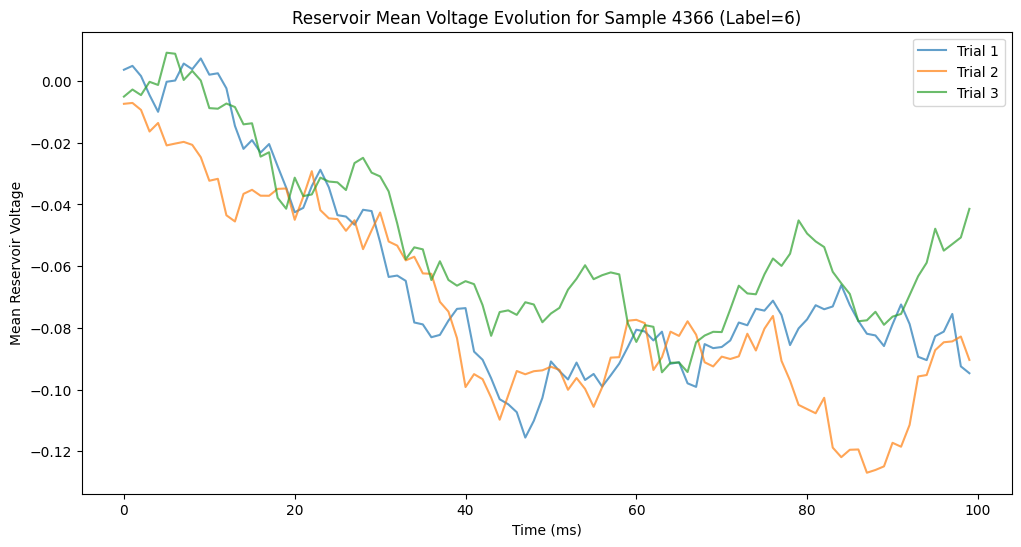

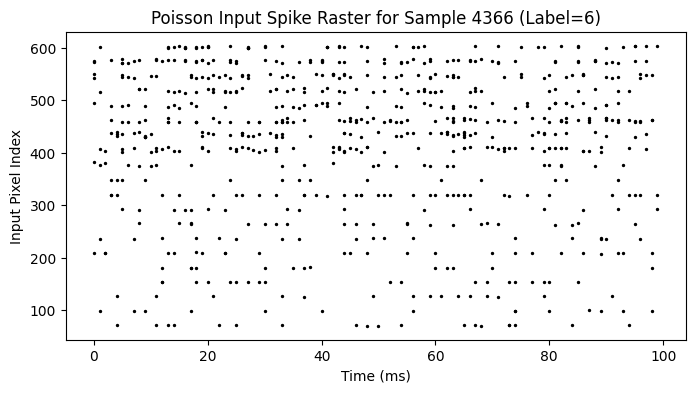

In [18]:
# === VISUALIZATION: Reservoir Dynamics Across Trials ===

print("\n=== Visualizing Reservoir Dynamics ===")
sample_idx = np.random.randint(0, X_test.shape[0])
image = X_test[sample_idx]
label = y_test[sample_idx]

print(f"Visualizing sample #{sample_idx}, True label = {label}")

N_trials_viz = 3  # visualize 3 runs
all_V = []

for trial in range(N_trials_viz):
    # Generate Poisson spike bins using your defined function
    spike_bins = image_to_spike_bins_poisson(image, t_sim=T_SIM, max_rate=MAX_RATE)
    V = np.full(N_RESERVOIR, V_REST, dtype=np.float32)
    refrac = np.zeros(N_RESERVOIR, dtype=np.float32)
    V_trace = []

    # Simulate reservoir and record voltage traces
    for t in range(int(T_SIM)):
        pixels = spike_bins[t]
        if pixels:
            input_contrib = Win[:, pixels].sum(axis=1).A.ravel()
            V += input_contrib

        # Leak term (Euler step)
        V += DT * (-V + V_REST) / TAU

        # Spike condition
        spiking = V >= V_THRESH
        if spiking.any():
            V[spiking] = V_RESET
            refrac[spiking] = REFRACTORY_MS
            V += W.dot(spiking.astype(np.float32))

        # Refractory decay
        mask = refrac > 0
        if mask.any():
            V[mask] = V_RESET
            refrac[mask] -= DT

        V_trace.append(V.copy())

    V_trace = np.array(V_trace)
    all_V.append(V_trace)

# === PLOT MEAN VOLTAGE EVOLUTION ===
plt.figure(figsize=(12, 6))
for i, V_trace in enumerate(all_V):
    plt.plot(np.mean(V_trace, axis=1), label=f"Trial {i+1}", alpha=0.7)
plt.title(f"Reservoir Mean Voltage Evolution for Sample {sample_idx} (Label={label})")
plt.xlabel("Time (ms)")
plt.ylabel("Mean Reservoir Voltage")
plt.legend()
plt.show()

# === VISUALIZE INPUT SPIKE RASTER ===
# Recreate input spike events from bins for visualization
spike_events = []
for t, pix_list in enumerate(spike_bins):
    for pix in pix_list:
        spike_events.append((pix, t))

if len(spike_events) > 0:
    spike_events = np.array(spike_events)
    plt.figure(figsize=(8, 4))
    plt.scatter(spike_events[:, 1], spike_events[:, 0], s=2, color='black')
    plt.title(f"Poisson Input Spike Raster for Sample {sample_idx} (Label={label})")
    plt.xlabel("Time (ms)")
    plt.ylabel("Input Pixel Index")
    plt.show()
else:
    print("No spikes generated for this image — try rerunning the cell.")


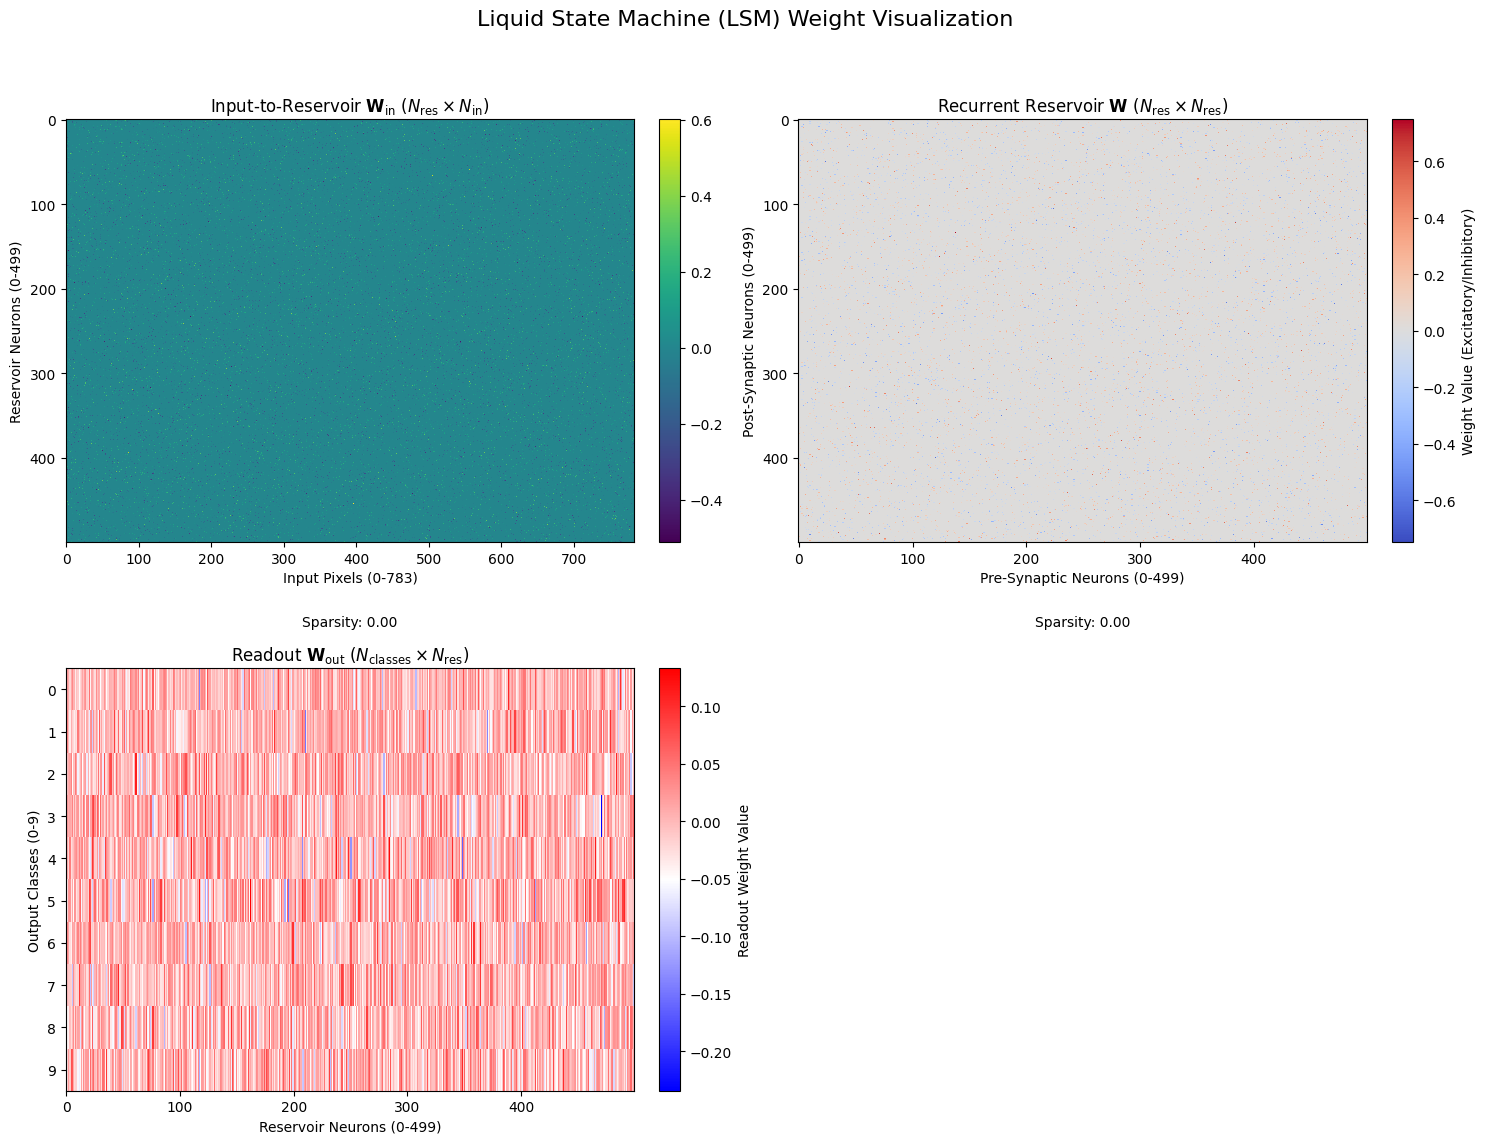

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse

# --- Configuration from your script ---
OUTPUT_DIR = '/content/drive/MyDrive/LSM_HDL_CPU'
N_INPUT = 784
N_RESERVOIR = 500

# --- Load the model weights ---
npz_path = os.path.join(OUTPUT_DIR, 'lsm_parameters.npz')

try:
    data = np.load(npz_path, allow_pickle=True)
    # The saved data contains the dense (or previously made dense) arrays
    Win_dense = data['Win'].astype(np.float32)
    W_dense = data['W'].astype(np.float32)
    Wout_dense = data['Wout'].astype(np.float32)

    # Re-create sparse for visualization of sparsity, though dense is fine for heatmaps
    Win = sparse.csr_matrix(Win_dense)
    W = sparse.csr_matrix(W_dense)
    Wout = Wout_dense

except FileNotFoundError:
    print(f"Error: Model file not found at {npz_path}. Please run the training script first.")
    # Exit or handle the error appropriately
    # For this example, we'll return, but in a full notebook you might raise an error
    exit()

# --- Visualization Function ---

def visualize_lsm_weights(Win, W, Wout):
    """
    Generates heatmaps for the LSM weight matrices:
    1. Input-to-Reservoir (Win)
    2. Recurrent Reservoir (W)
    3. Reservoir-to-Output (Wout)
    """

    fig = plt.figure(figsize=(15, 12))
    plt.suptitle('Liquid State Machine (LSM) Weight Visualization', fontsize=16)

    # 1. Input-to-Reservoir Weight Matrix (Win)
    ax1 = fig.add_subplot(2, 2, 1)

    # Use the dense array for the heatmap
    Win_array = Win.toarray()

    # We use a custom color scheme to highlight the sparsity and weight distribution
    cbar1 = ax1.imshow(Win_array, aspect='auto', cmap='viridis',
                       interpolation='nearest')
    plt.colorbar(cbar1, ax=ax1, orientation='vertical', fraction=0.046, pad=0.04)
    ax1.set_title(r'Input-to-Reservoir $\mathbf{W}_{\text{in}}$ ($N_{\text{res}} \times N_{\text{in}}$)')
    ax1.set_xlabel(f'Input Pixels (0-{N_INPUT-1})')
    ax1.set_ylabel(f'Reservoir Neurons (0-{N_RESERVOIR-1})')
    ax1.text(0.5, -0.2, f'Sparsity: {1 - Win.nnz / Win.size:.2f}',
             transform=ax1.transAxes, ha='center')

    # 2. Recurrent Reservoir Weight Matrix (W)
    ax2 = fig.add_subplot(2, 2, 2)
    W_array = W.toarray()

    # Recurrent weights can be positive (excitatory) or negative (inhibitory)
    # Use a diverging color map centered at zero
    max_abs_w = np.max(np.abs(W_array))
    cbar2 = ax2.imshow(W_array, aspect='auto', cmap='coolwarm',
                       interpolation='nearest', vmin=-max_abs_w, vmax=max_abs_w)
    plt.colorbar(cbar2, ax=ax2, orientation='vertical', fraction=0.046, pad=0.04,
                 label='Weight Value (Excitatory/Inhibitory)')
    ax2.set_title(r'Recurrent Reservoir $\mathbf{W}$ ($N_{\text{res}} \times N_{\text{res}}$)')
    ax2.set_xlabel(f'Pre-Synaptic Neurons (0-{N_RESERVOIR-1})')
    ax2.set_ylabel(f'Post-Synaptic Neurons (0-{N_RESERVOIR-1})')
    ax2.text(0.5, -0.2, f'Sparsity: {1 - W.nnz / W.size:.2f}',
             transform=ax2.transAxes, ha='center')

    # 3. Readout Weight Matrix (Wout)
    ax3 = fig.add_subplot(2, 2, 3)

    # Wout connects reservoir neurons to the 10 output classes
    cbar3 = ax3.imshow(Wout, aspect='auto', cmap='bwr',
                       interpolation='nearest', vmin=np.min(Wout), vmax=np.max(Wout))
    plt.colorbar(cbar3, ax=ax3, orientation='vertical', fraction=0.046, pad=0.04,
                 label='Readout Weight Value')
    ax3.set_title(r'Readout $\mathbf{W}_{\text{out}}$ ($N_{\text{classes}} \times N_{\text{res}}$)')
    ax3.set_xlabel(f'Reservoir Neurons (0-{N_RESERVOIR-1})')
    ax3.set_ylabel('Output Classes (0-9)')
    ax3.set_yticks(np.arange(Wout.shape[0]))
    ax3.set_yticklabels([str(c) for c in data['classes']]) # Use actual class labels

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
    plt.show()

# --- Run Visualization ---
visualize_lsm_weights(Win, W, Wout_dense)

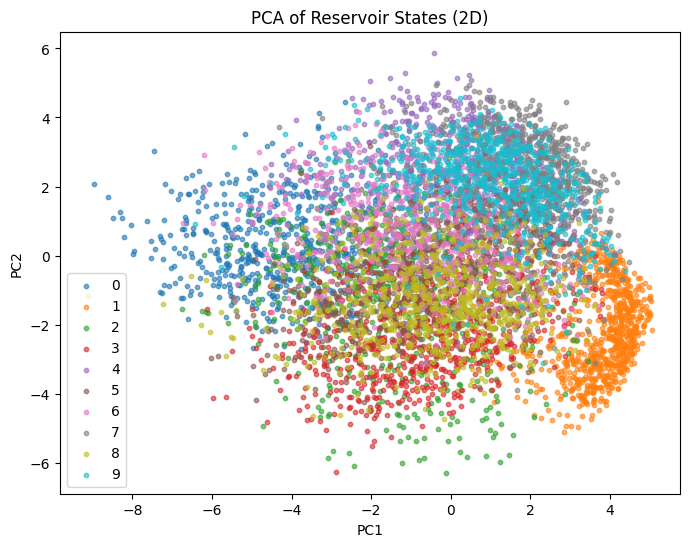

In [16]:
from sklearn.decomposition import PCA

R_test_sample = R_test[:7000]  # take subset to visualize
y_sample = y_test[:7000]

pca = PCA(n_components=2)
proj = pca.fit_transform(R_test_sample)

plt.figure(figsize=(8,6))
for c in np.unique(y_sample):
    mask = y_sample == c
    plt.scatter(proj[mask,0], proj[mask,1], label=str(c), s=10, alpha=0.6)
plt.title('PCA of Reservoir States (2D)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()
